In [1]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import hdbscan

from os.path import join
from IPython import display
from IPython.display import Image
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure, f1_score # и другие метрики
from sklearn.cluster import KMeans, AgglomerativeClustering # а также другие алгоритмы
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from my_awesome_eda import run_eda

In [2]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

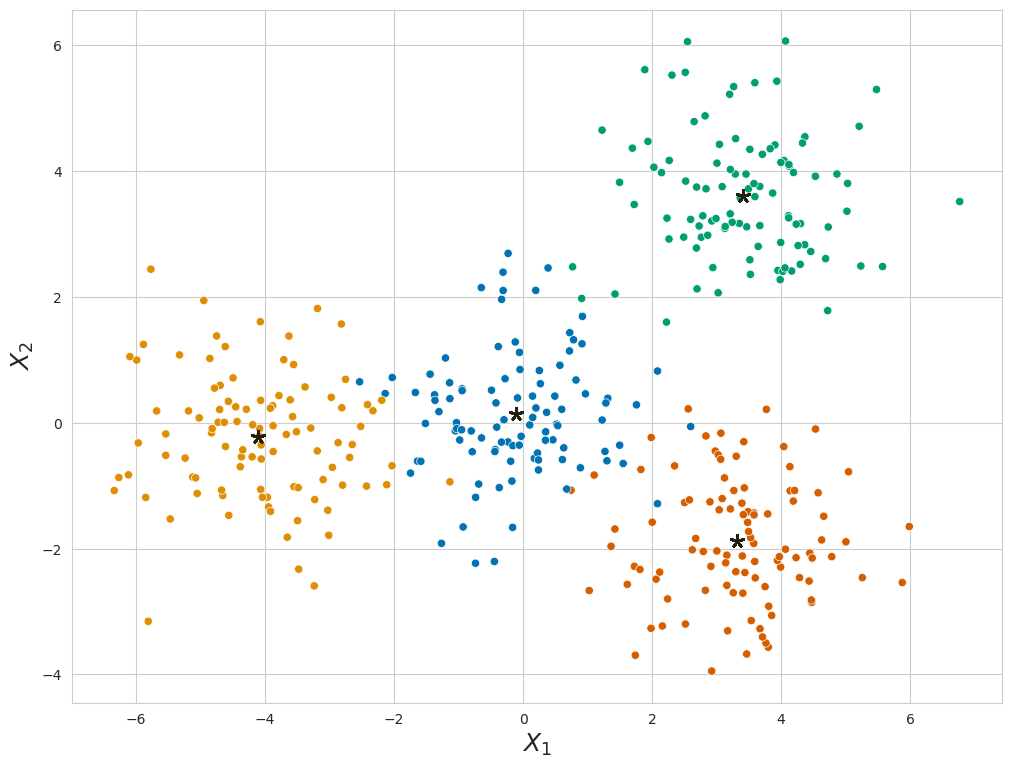

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        assert self.centroids is not None, "Модель не обучена, используйте fit"
        
        dists = []
        for centroid in self.centroids:
            dists.append(self._calculate_distance(X, centroid))
        dists = np.concatenate(dists, axis=1)
        
        cluster_labels = np.argmin(dists, axis=1)
            
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        dist = np.linalg.norm(X - centroid, axis=1)
        
        return dist.reshape(-1, 1)
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

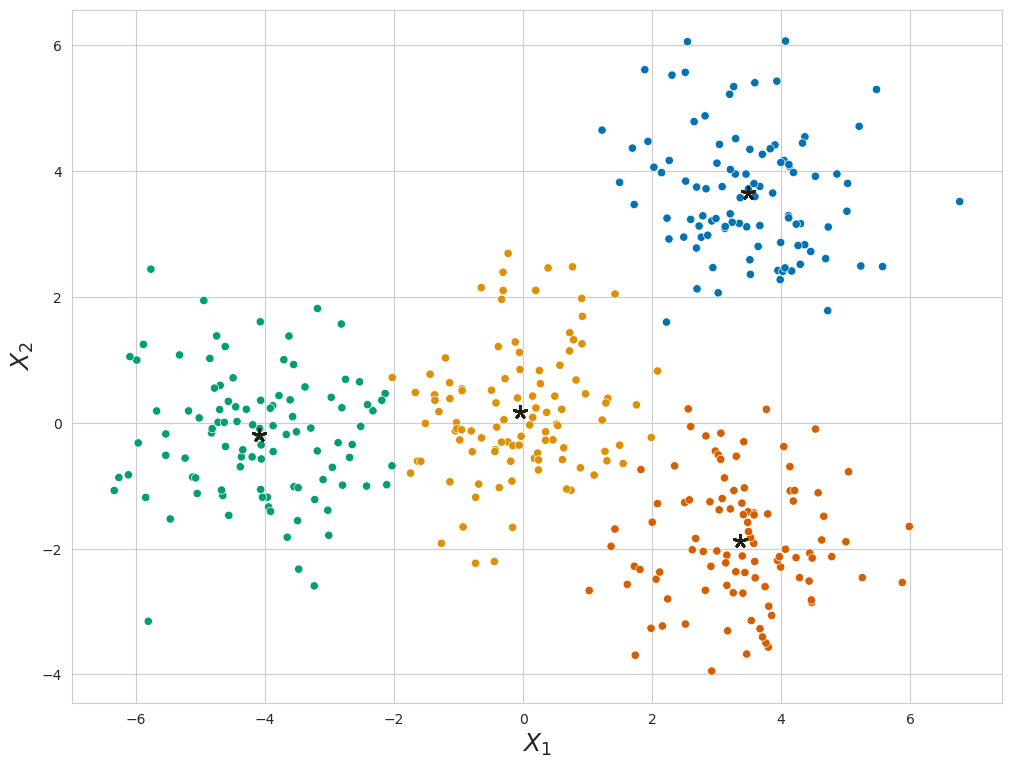

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [7]:
mk1 = MyKMeans(n_clusters=4, init="random", max_iter=30, visualize=True)
mk1.fit(X)

In [8]:
y_pred1 = mk1.predict(X)
sil1 = silhouette_score(X, y_pred1)
print(f"Silhuette score: {round(sil1, 4)}")

Silhuette score: 0.5643


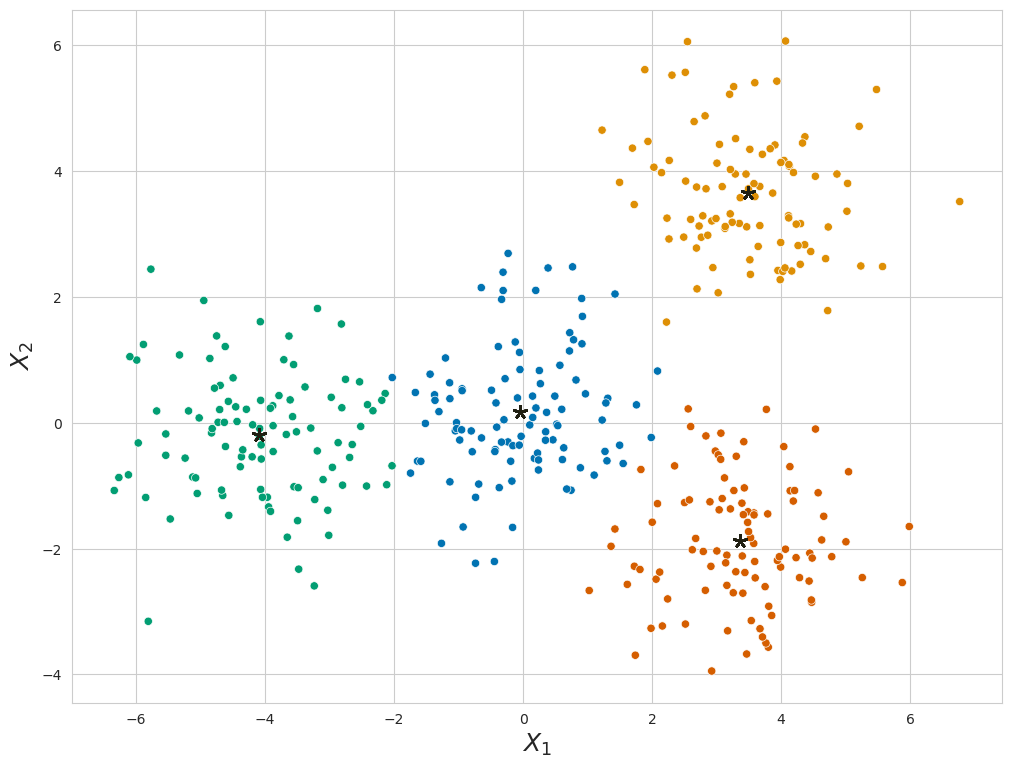

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [9]:
mk2 = MyKMeans(n_clusters=4, init="sample", max_iter=30, visualize=True)
mk2.fit(X)

In [10]:
y_pred2 = mk2.predict(X)
sil2 = silhouette_score(X, y_pred2)
print(f"Silhuette score: {round(sil2, 4)}")

Silhuette score: 0.5643


Честно, не вижу разницы в выборе метода инициализации для нашего игрушечного примера. Но на лекции говорили, что выбор рандомных координат - неоптимальное решение и его практически не используют.

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [11]:
data = load_digits()
X, y = data.data, data.target

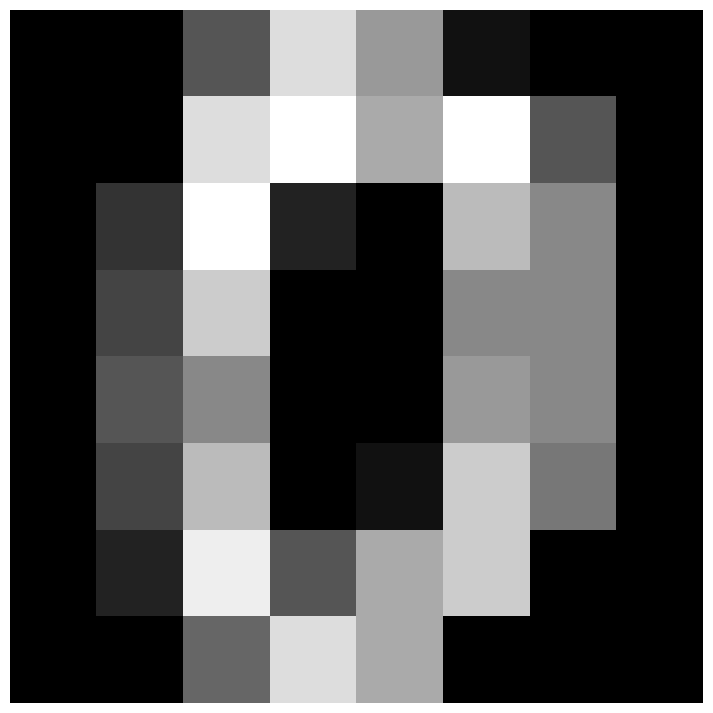

In [12]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [13]:
def algorithm_selection(X, y=None, n_clust=2, distances=("euclidean", "manhattan", "minkowski", "cosine"),
                        algorithms=("average", "single", "complete"),
                        metrics=("homogeneity", "completeness", "v_measure", "silhouette")):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список метрик расстояния ("euclidean", "manhattan", "minkowsky", "cosine")
        :param algorithm: параметр linkage ("average", "single", "complete")
        :param metrics: список возможных метрик качества кластеризации ("silhouette", "homogeneity", "completeness", "v_measure")
    :return compare_dataframe: таблица с метриками кластеризации
    """

    compare_dataframe = pd.DataFrame(columns=["distance", "linkage", "homogenity", "completeness", "v_measure", "silhouette"])
    
    for distance in distances:
        for algorithm in algorithms:
            model = AgglomerativeClustering(n_clusters=n_clust, metric=distance, linkage=algorithm)
            y_pred = model.fit_predict(X)
            
            silhouette = silhouette_score(X, labels=y_pred, metric=distance)

            # для рассчета следующих метрик мы должны знать таргет, но мы можем его не знать
            if y is not None:
                homo, coml, v_m = homogeneity_completeness_v_measure(y, y_pred)
            else:
                homo, coml, v_m = np.nan, np.nan, np.nan
            
            compare_dataframe.loc[len(compare_dataframe)] = [distance, algorithm, homo, coml, v_m, silhouette]

    
    return compare_dataframe

In [14]:
compare_dataframe = algorithm_selection(X, y, n_clust=10)  # у нас цифры, от 0 до 9, следовательно 10 кластеров
compare_dataframe.head(10)

distance   linkage  homogenity  completeness  v_measure  silhouette
0  euclidean   average    0.655393      0.782342   0.713263    0.146625
1  euclidean    single    0.005056      0.273755   0.009929   -0.133621
2  euclidean  complete    0.590549      0.637772   0.613253    0.119271
3  manhattan   average    0.566751      0.778942   0.656117    0.105238
4  manhattan    single    0.005102      0.276237   0.010019   -0.203816
5  manhattan  complete    0.646372      0.686109   0.665648    0.160617
6  minkowski   average    0.655393      0.782342   0.713263    0.146625
7  minkowski    single    0.005056      0.273755   0.009929   -0.133621
8  minkowski  complete    0.590549      0.637772   0.613253    0.119271
9     cosine   average    0.648268      0.808762   0.719676    0.218229

In [15]:
# Давайте будем ориентироваться на силуэт
compare_dataframe.sort_values(by='silhouette', ascending=False)

distance   linkage  homogenity  completeness  v_measure  silhouette
9      cosine   average    0.648268      0.808762   0.719676    0.218229
5   manhattan  complete    0.646372      0.686109   0.665648    0.160617
0   euclidean   average    0.655393      0.782342   0.713263    0.146625
6   minkowski   average    0.655393      0.782342   0.713263    0.146625
11     cosine  complete    0.528727      0.577415   0.551999    0.144179
8   minkowski  complete    0.590549      0.637772   0.613253    0.119271
2   euclidean  complete    0.590549      0.637772   0.613253    0.119271
3   manhattan   average    0.566751      0.778942   0.656117    0.105238
1   euclidean    single    0.005056      0.273755   0.009929   -0.133621
7   minkowski    single    0.005056      0.273755   0.009929   -0.133621
4   manhattan    single    0.005102      0.276237   0.010019   -0.203816
10     cosine    single    0.005050      0.273389   0.009916   -0.281789

Исходя из того, что чем ближе силуэт к единице, тем лучше, можно сказать, что лучшими параметрами будет distance - cosine, linkage - average. 

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [16]:
DATA_PATH = "../data_folder/raw_data/"
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

##### YOUR TURN TO CODE:

Praise the Omnissiah! Welcome to the Sanctum of Exploratory Data Analysis.

Number of Observations (Rows): 10000
Number of Parameters (Columns): 9

Data Types of Each Column:
FSC-A    float64
SSC-A    float64
HLA-DR   float64
CD3      float64
CD45     float64
CD14     float64
CD56     float64
CD19     float64
CD11c    float64

Numerical features: FSC-A, SSC-A, HLA-DR, CD3, CD45, CD14, CD56, CD19, CD11c
String features: 0
Categorical features: 0

Counts and Frequencies for Categorical Features:

Descriptive Statistics for Numerical Features:
          FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
count  10000.00  10000.00  10000.00  10000.00  10000.00  10000.00  10000.00   
mean       0.96      0.17      1.79      3.28      5.17      1.10      0.41   
std        0.50      0.19      2.03      2.11      0.52      1.38      1.18   
min        0.14      0.02     -7.63     -2.52     -8.33     -8.83    -12.36   
25%        0.80      0.11      0.28      1.40      4.92   

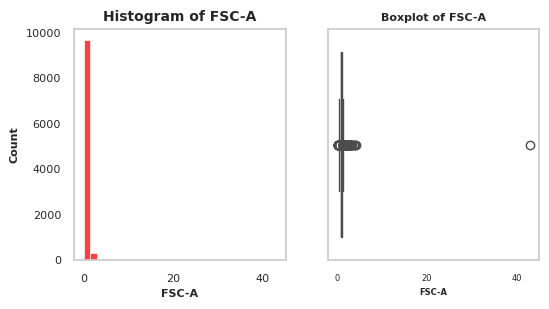

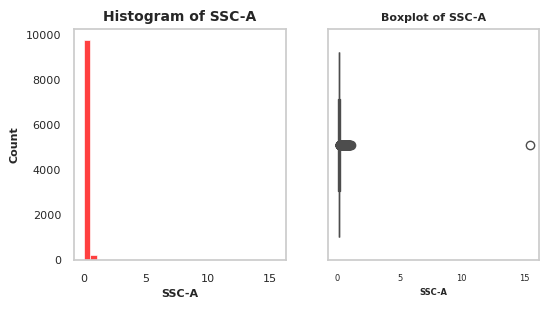

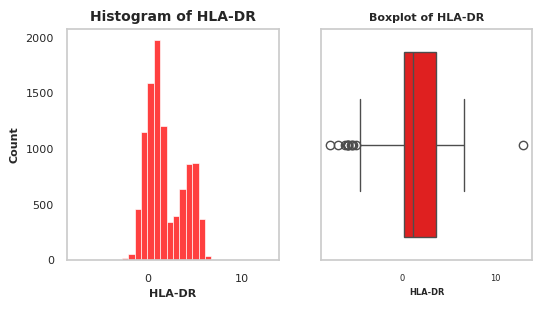

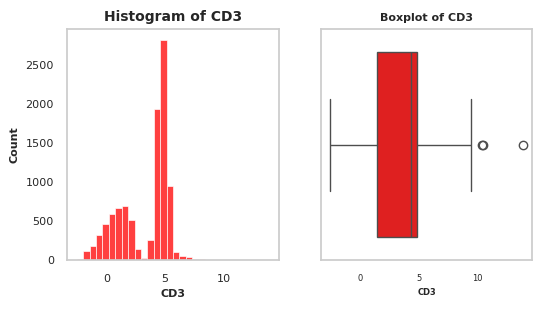

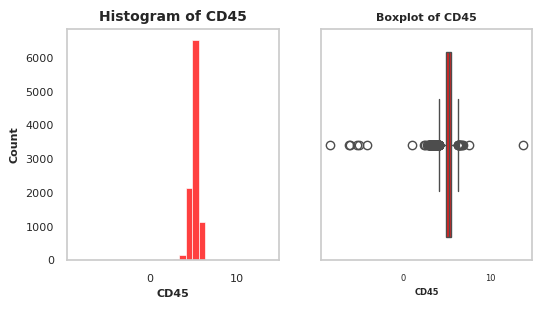

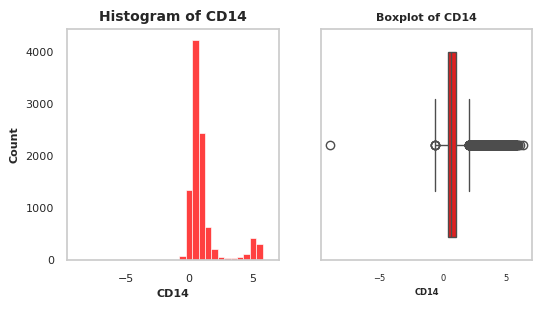

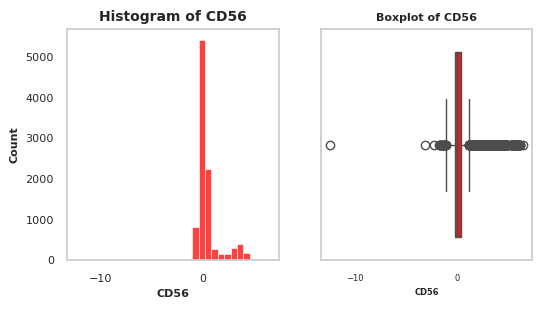

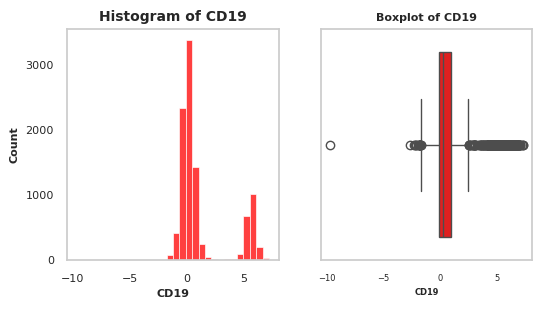

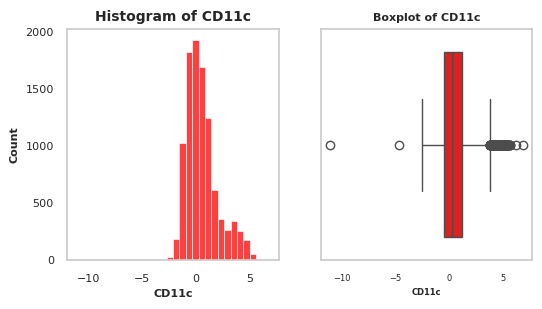


Correlation Heatmap:


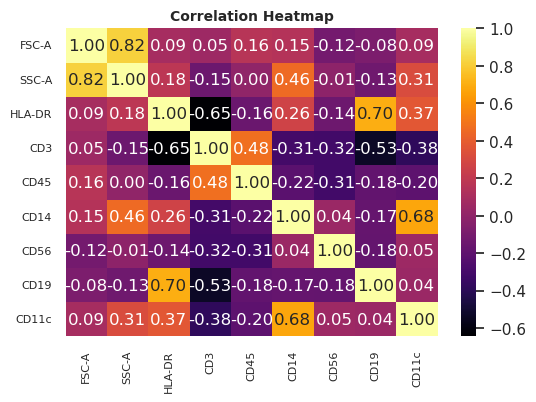


Outliers for Numerical Features:
FSC-A: 538
SSC-A: 1132
HLA-DR: 12
CD3: 3
CD45: 182
CD14: 1136
CD56: 1337
CD19: 2071
CD11c: 515

Missing Values:
Total Missing Values: 0
Rows with Missing Values: 0
Columns with Missing Values: 

Missing Values Proportion:


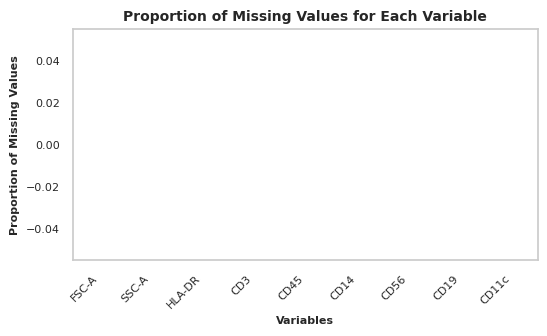


Duplicate Rows:
Number of Duplicate Rows: 0

May the data guide you, and the Omnissiah bless your analysis.


In [17]:
run_eda(fc_data)

У нас 10000 наблюдений, 9 маркеров, все числовые, есть достаточно сильные выбросы (см. боксплоты и табличку с квартилями), давайте уберем их. Пропущенных значений нет. Есть положительная корреляция между FSC-A и SSC-A, HLA-DR и CD19, CD14 и CD11c. Есть маркеры с разными размерностями, будем делать стандартизацию.

In [18]:
cleaned_fc_data = fc_data.drop(labels=[np.argmax(fc_data['FSC-A']), 
                                     np.argmax(fc_data['SSC-A']), 
                                     np.argmin(fc_data['CD14']),
                                     np.argmin(fc_data['CD56']),
                                     np.argmin(fc_data['CD19']),
                                     np.argmin(fc_data['CD11c'])
                                    ], axis=0, inplace=False)

Praise the Omnissiah! Welcome to the Sanctum of Exploratory Data Analysis.

Number of Observations (Rows): 9999
Number of Parameters (Columns): 9

Data Types of Each Column:
FSC-A    float64
SSC-A    float64
HLA-DR   float64
CD3      float64
CD45     float64
CD14     float64
CD56     float64
CD19     float64
CD11c    float64

Numerical features: FSC-A, SSC-A, HLA-DR, CD3, CD45, CD14, CD56, CD19, CD11c
String features: 0
Categorical features: 0

Counts and Frequencies for Categorical Features:

Descriptive Statistics for Numerical Features:
         FSC-A    SSC-A   HLA-DR      CD3     CD45     CD14     CD56     CD19  \
count  9999.00  9999.00  9999.00  9999.00  9999.00  9999.00  9999.00  9999.00   
mean      0.96     0.16     1.79     3.28     5.17     1.10     0.41     1.22   
std       0.27     0.11     2.02     2.11     0.51     1.37     1.17     2.28   
min       0.14     0.02    -7.63    -2.52    -8.33    -0.64    -3.08    -2.64   
25%       0.80     0.11     0.28     1.40     4.9

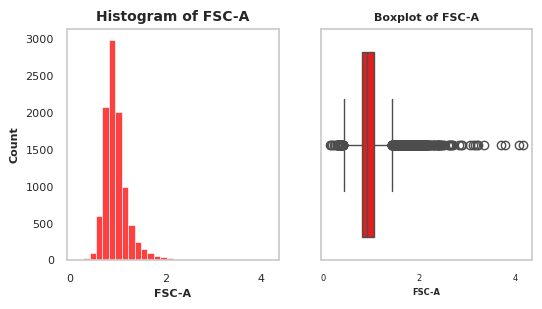

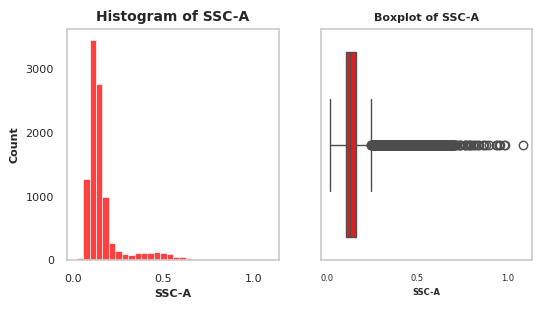

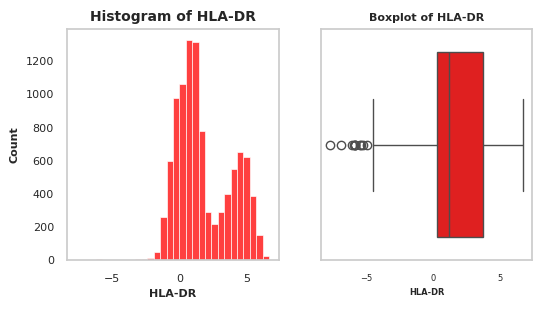

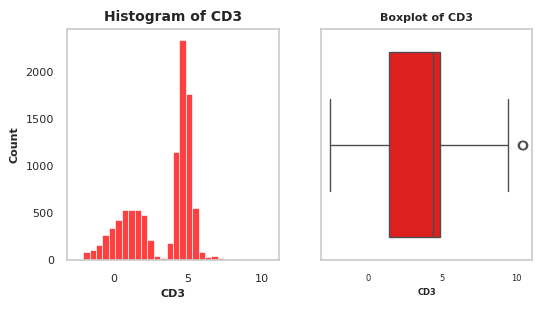

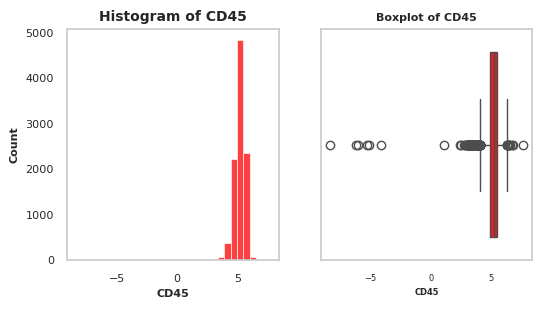

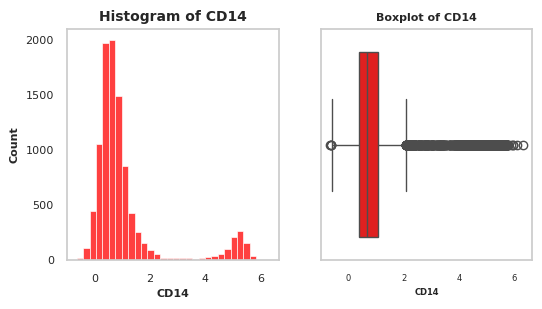

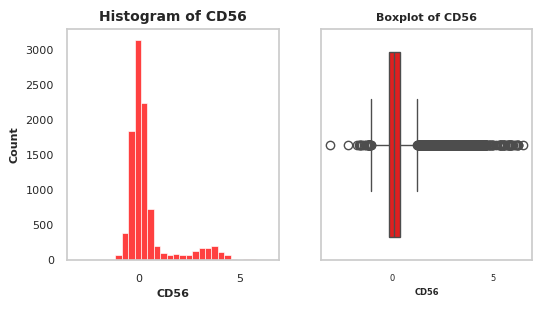

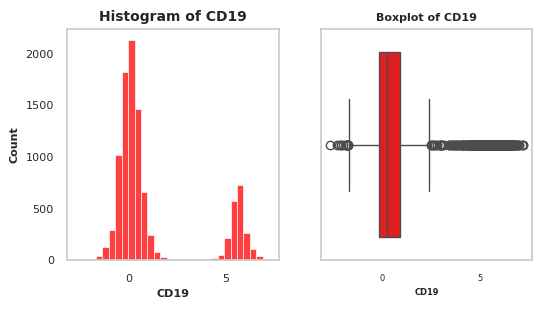

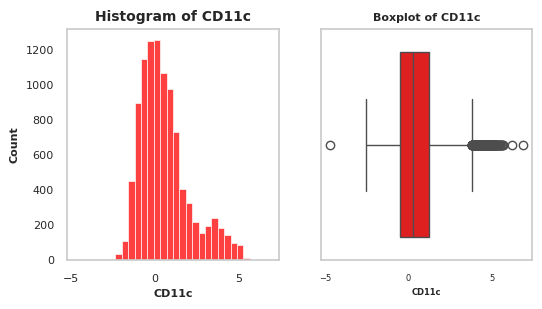


Correlation Heatmap:


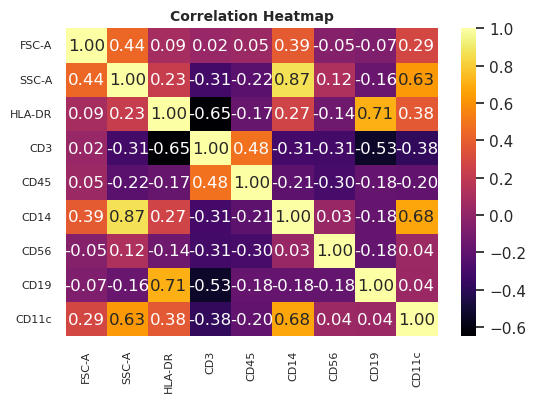


Outliers for Numerical Features:
FSC-A: 537
SSC-A: 1131
HLA-DR: 11
CD3: 2
CD45: 181
CD14: 1135
CD56: 1336
CD19: 2070
CD11c: 514

Missing Values:
Total Missing Values: 0
Rows with Missing Values: 0
Columns with Missing Values: 

Missing Values Proportion:


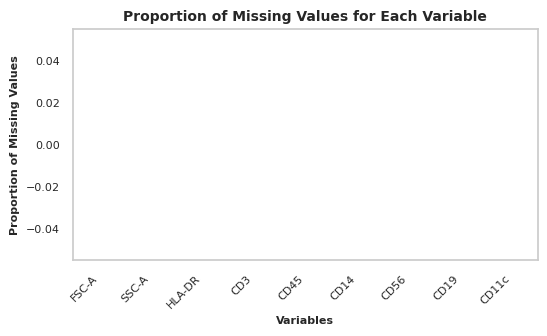


Duplicate Rows:
Number of Duplicate Rows: 0

May the data guide you, and the Omnissiah bless your analysis.


In [19]:
# Давайте посмотрим, как хорошо мы справились
run_eda(cleaned_fc_data)

Из 10000 наблюдений у нас осталось 9999 (Воу!). Значит все эти выбросы обусловлены одним наблюдением! И у нас немного поменялась картина корреляции: осталась положительная корреляция HLA-DR и CD19, CD14 и CD11c, также наблюдается положительная корреляция SSC-A и CD14, SSC-A и CD11c. Также наблюдается отрицательная корреляция между HLA-DR и CD3.

In [20]:
scaler = StandardScaler()
scaled_cleaned_fc_data = scaler.fit_transform(cleaned_fc_data)

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [21]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

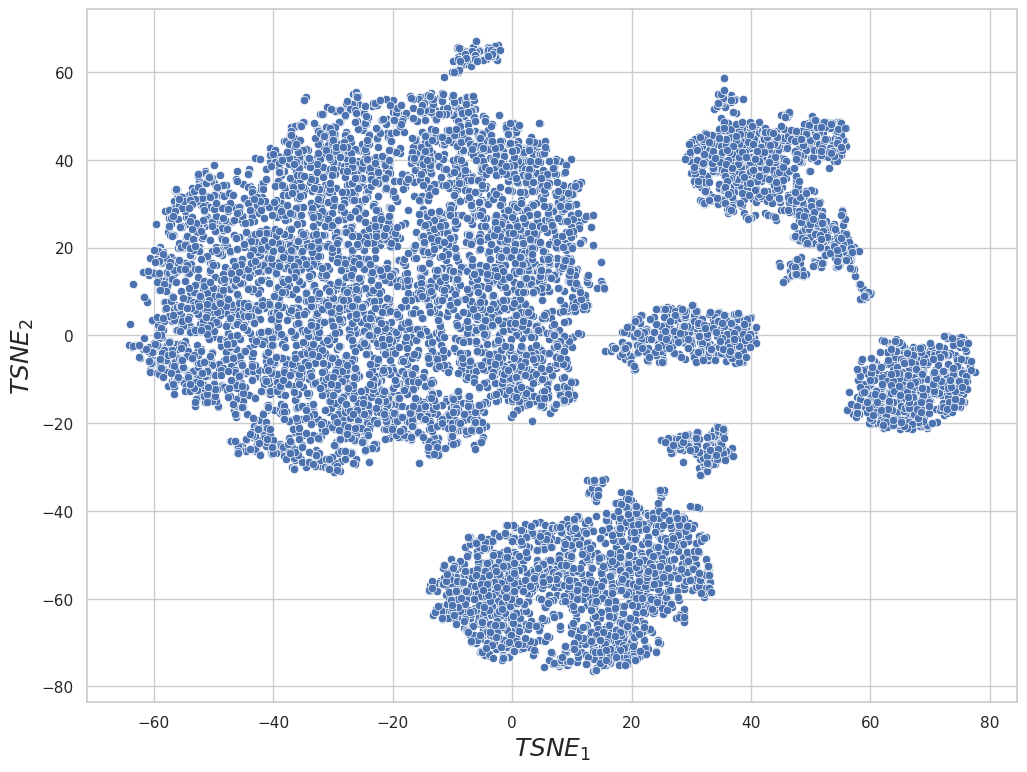

In [22]:
tsne_res = plot_tsne(scaled_cleaned_fc_data)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

Если долго смотреть на картинку, можно увидеть, что кластеров все-таки 5.

#### KMeans

In [23]:
kmeans = KMeans(5)
kmeans.fit(scaled_cleaned_fc_data)
y_pred = kmeans.predict(scaled_cleaned_fc_data)
sil = silhouette_score(scaled_cleaned_fc_data, y_pred)
print(f"Silhuette score: {round(sil, 4)}")

Silhuette score: 0.5128


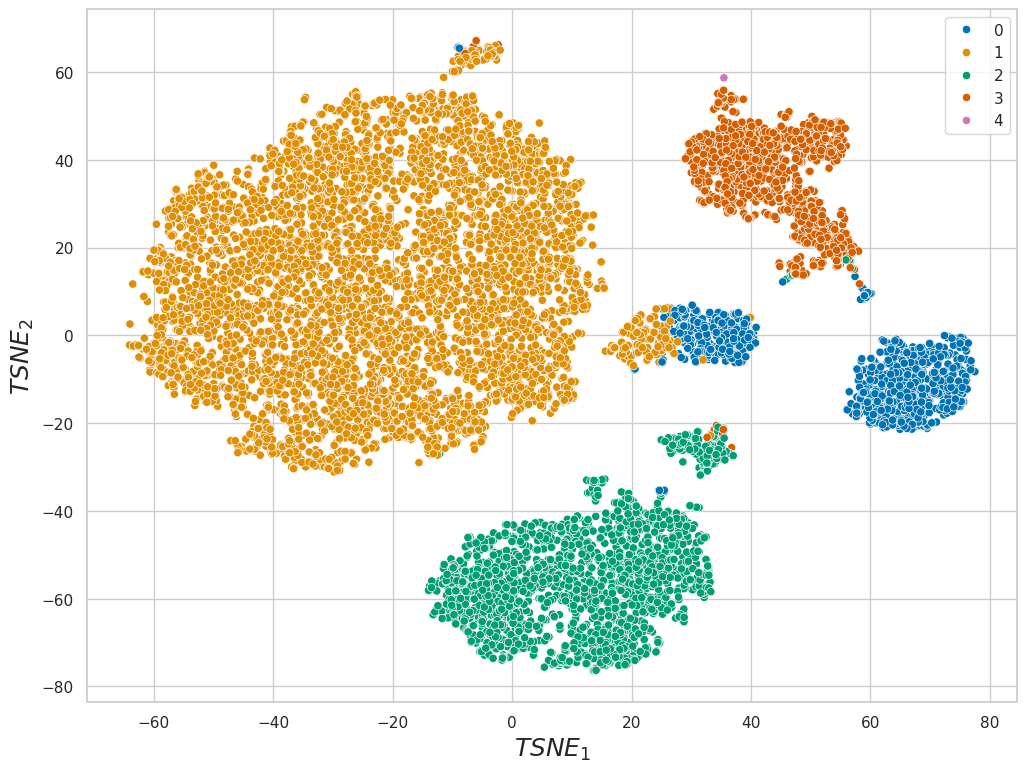

In [24]:
tsne_res_kmeans = plot_tsne(scaled_cleaned_fc_data, color=y_pred)

#### MyKMeans

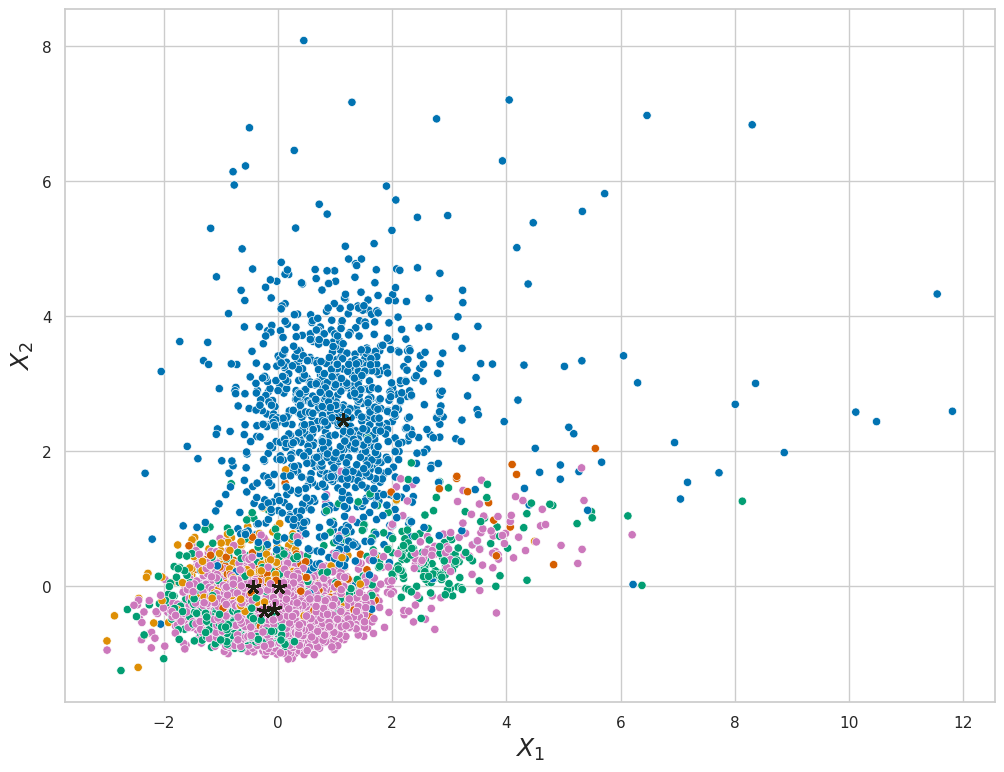

Silhuette score: 0.4376


In [25]:
mkmeans = MyKMeans(n_clusters=5, init="sample", max_iter=10, visualize=True)
mkmeans.fit(scaled_cleaned_fc_data)
y_pred = mkmeans.predict(scaled_cleaned_fc_data)
sil = silhouette_score(scaled_cleaned_fc_data, y_pred)
print(f"Silhuette score: {round(sil, 4)}")

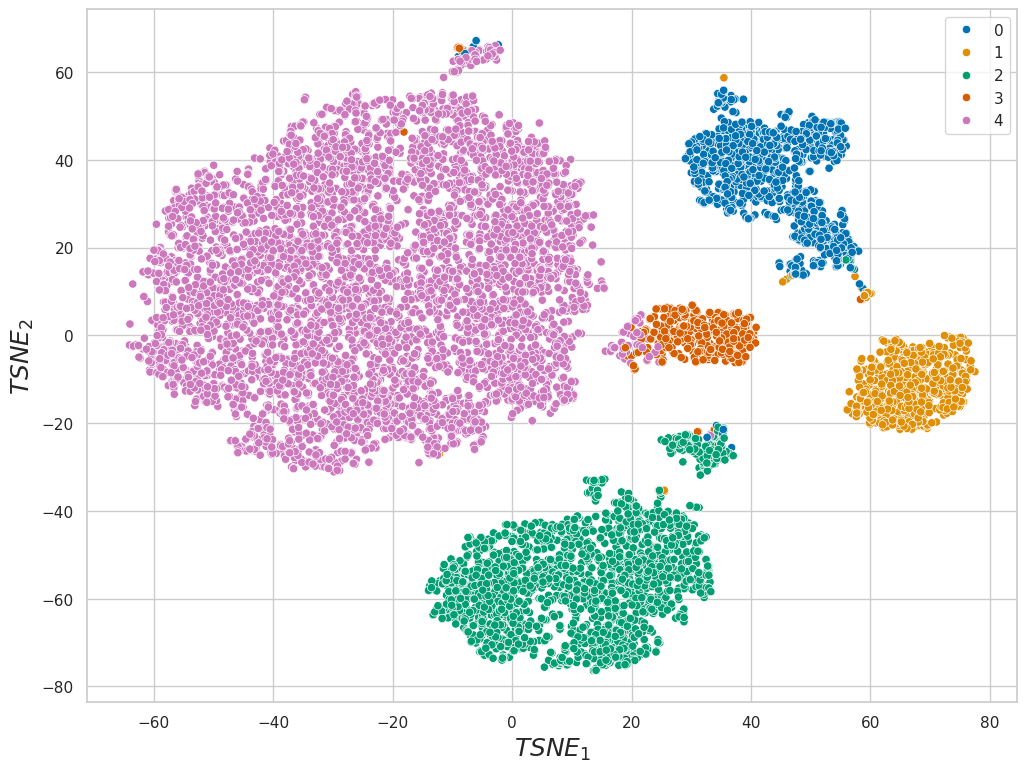

In [26]:
tsne_res_mkm = plot_tsne(scaled_cleaned_fc_data, color=y_pred)

Силуэт получился хуже, чем у встроенного KMeans, работал долго)

#### Agglomaretive Clustering

In [27]:
agg_clustering_alg = algorithm_selection(scaled_cleaned_fc_data, n_clust=5)
agg_clustering_alg.sort_values(by='silhouette', ascending=False)

distance   linkage  homogenity  completeness  v_measure  silhouette
4   manhattan    single         NaN           NaN        NaN    0.619393
1   euclidean    single         NaN           NaN        NaN    0.594477
7   minkowski    single         NaN           NaN        NaN    0.594477
0   euclidean   average         NaN           NaN        NaN    0.578083
6   minkowski   average         NaN           NaN        NaN    0.578083
9      cosine   average         NaN           NaN        NaN    0.562350
3   manhattan   average         NaN           NaN        NaN    0.490350
5   manhattan  complete         NaN           NaN        NaN    0.354501
2   euclidean  complete         NaN           NaN        NaN    0.341479
8   minkowski  complete         NaN           NaN        NaN    0.341479
11     cosine  complete         NaN           NaN        NaN    0.306325
10     cosine    single         NaN           NaN        NaN   -0.358608

Хорошие параметры manhattan/single

In [28]:
agg = AgglomerativeClustering(n_clusters=5, metric='manhattan', linkage='single')
y_pred_agg = agg.fit_predict(scaled_cleaned_fc_data)
sil = silhouette_score(scaled_cleaned_fc_data, y_pred_agg)
print(f"Silhuette score: {round(sil, 4)}")

Silhuette score: 0.5809


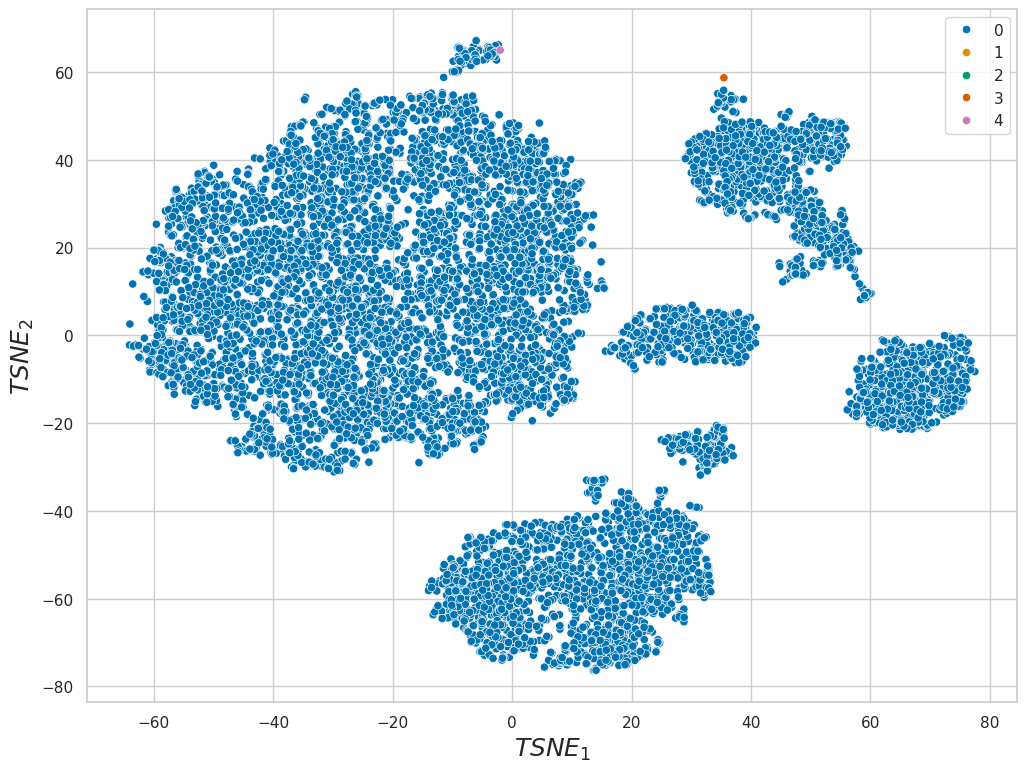

In [29]:
tsne_res_agg = plot_tsne(scaled_cleaned_fc_data, color=y_pred_agg)

Несмотря на хороший скор силуэта, картинка не радует глаз, можно попробовать с другими параметрами.

In [30]:
agg2 = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='average')
y_pred_agg2 = agg2.fit_predict(scaled_cleaned_fc_data)
sil = silhouette_score(scaled_cleaned_fc_data, y_pred_agg2)
print(f"Silhuette score: {round(sil, 4)}")

Silhuette score: 0.5781


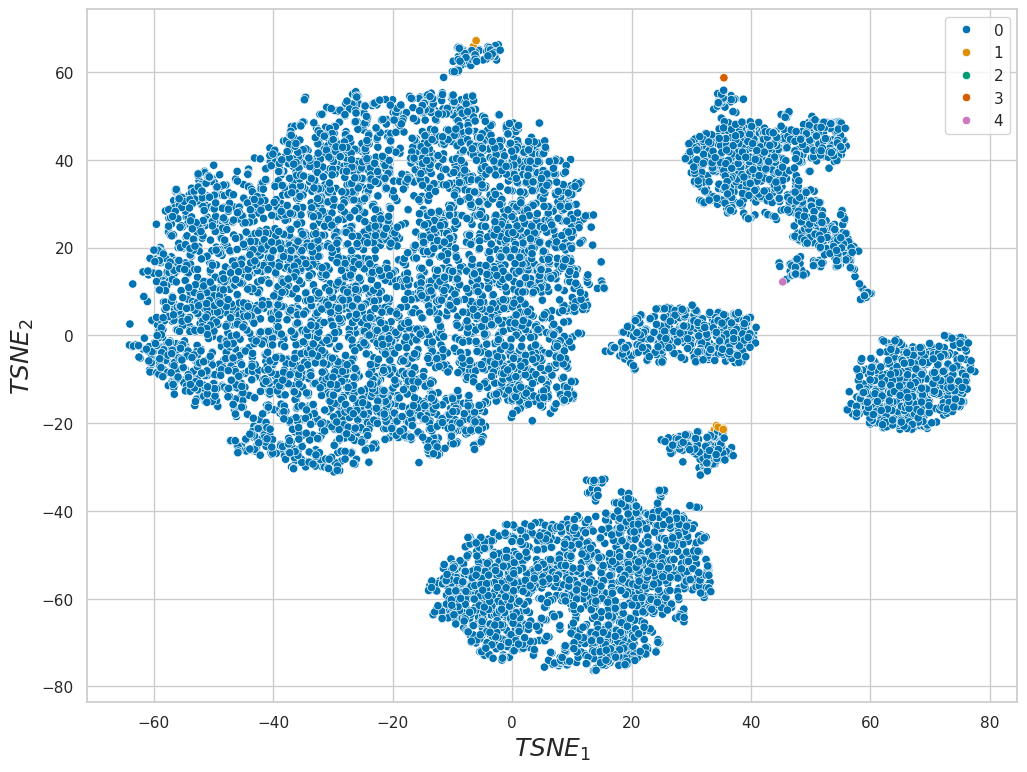

In [31]:
tsne_res_agg2 = plot_tsne(scaled_cleaned_fc_data, color=y_pred_agg2)

Давайте попробуем linkage='ward'. Я не стала включать его в функцию для подбора гиперпараметров, потому что он используется только с metric='euclidean' и вариант только один.

In [32]:
agg3 = AgglomerativeClustering(n_clusters=5)
y_pred_agg3 = agg3.fit_predict(scaled_cleaned_fc_data)
sil = silhouette_score(scaled_cleaned_fc_data, y_pred_agg3)
print(f"Silhuette score: {round(sil, 4)}")

Silhuette score: 0.4996


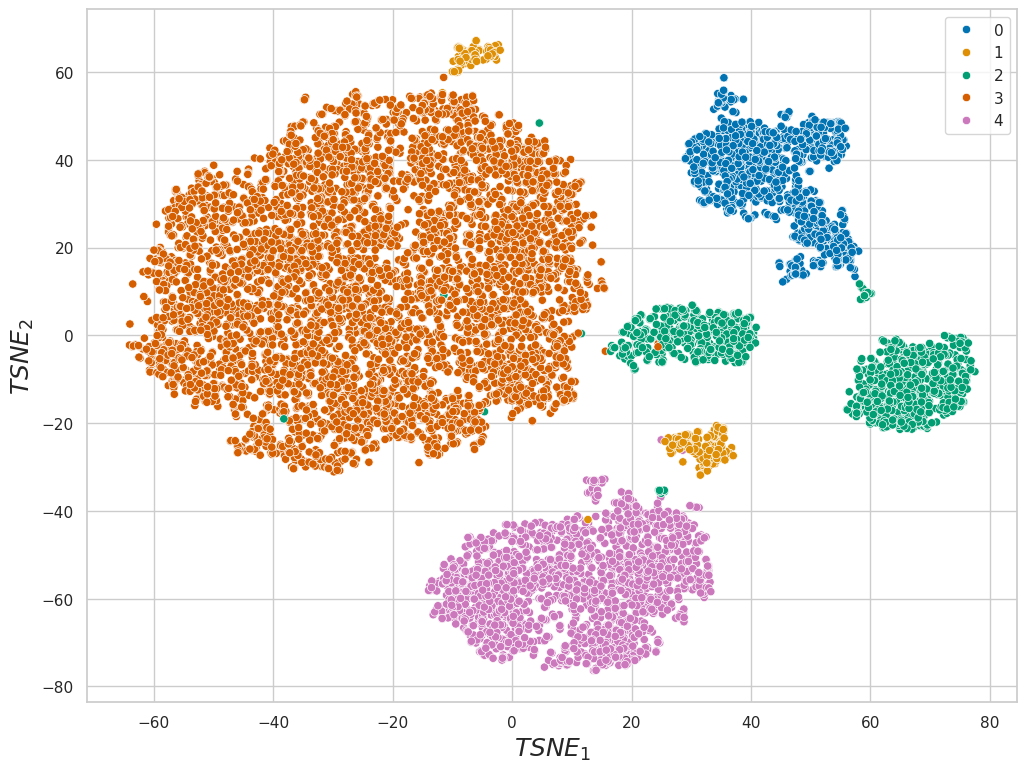

In [33]:
tsne_res_agg3 = plot_tsne(scaled_cleaned_fc_data, color=y_pred_agg3)

Силуэт хуже - картинка приятнее.

#### HDBSCAN

In [34]:
def algorithm_selection2(X, metric=("euclidean", "manhattan"),
                        min_cluster_size=(25, 50, 75),
                        min_samples=(1, 5, 10),
                        cluster_selection_epsilon = (0, 0.5, 1.)):
    """
    Простите, пока без докстринги
    """

    compare_dataframe = pd.DataFrame(columns=["metric", "min_cluster_size", "min_samples", "epsilon", "silhouette"])
    
    for metr in metric:
        for size in min_cluster_size:
            for samples in min_samples: 
                for epsilon in cluster_selection_epsilon:
                    clusterer = hdbscan.HDBSCAN(metric=metr, min_cluster_size=size, min_samples=samples, cluster_selection_epsilon=epsilon)
                    y_pred_hdb = clusterer.fit_predict(X)
                    
                    silhouette = silhouette_score(X, labels=y_pred_hdb, metric=metr)
                    
                    compare_dataframe.loc[len(compare_dataframe)] = [metr, size, samples, epsilon, silhouette]

    
    return compare_dataframe

In [35]:
clustering_alg = algorithm_selection2(scaled_cleaned_fc_data)
clustering_alg.sort_values(by='silhouette', ascending=False).head(15)

metric  min_cluster_size  min_samples  epsilon  silhouette
19  euclidean                75            1      0.5    0.484815
18  euclidean                75            1      0.0    0.484815
5   euclidean                25            5      1.0    0.483385
12  euclidean                50            5      0.0    0.483385
4   euclidean                25            5      0.5    0.483385
3   euclidean                25            5      0.0    0.483385
21  euclidean                75            5      0.0    0.483385
14  euclidean                50            5      1.0    0.483385
13  euclidean                50            5      0.5    0.483385
22  euclidean                75            5      0.5    0.483385
23  euclidean                75            5      1.0    0.483385
16  euclidean                50           10      0.5    0.478521
17  euclidean                50           10      1.0    0.478521
15  euclidean                50           10      0.0    0.478521
8   euclidean                25           10      1.0    0.478521

Наверняка можно сказать только одно - будем использовать евклидово расстояние. Минимальный размер кластера - 75, минимальное количество образцов - 1, эпсилон 0 или 0.5

In [36]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=75, min_samples=1, cluster_selection_epsilon=0)
y_pred_hdb = clusterer.fit_predict(scaled_cleaned_fc_data)
sil = silhouette_score(scaled_cleaned_fc_data, y_pred_hdb)
print(f"Silhuette score: {round(sil, 4)}")

Silhuette score: 0.4848


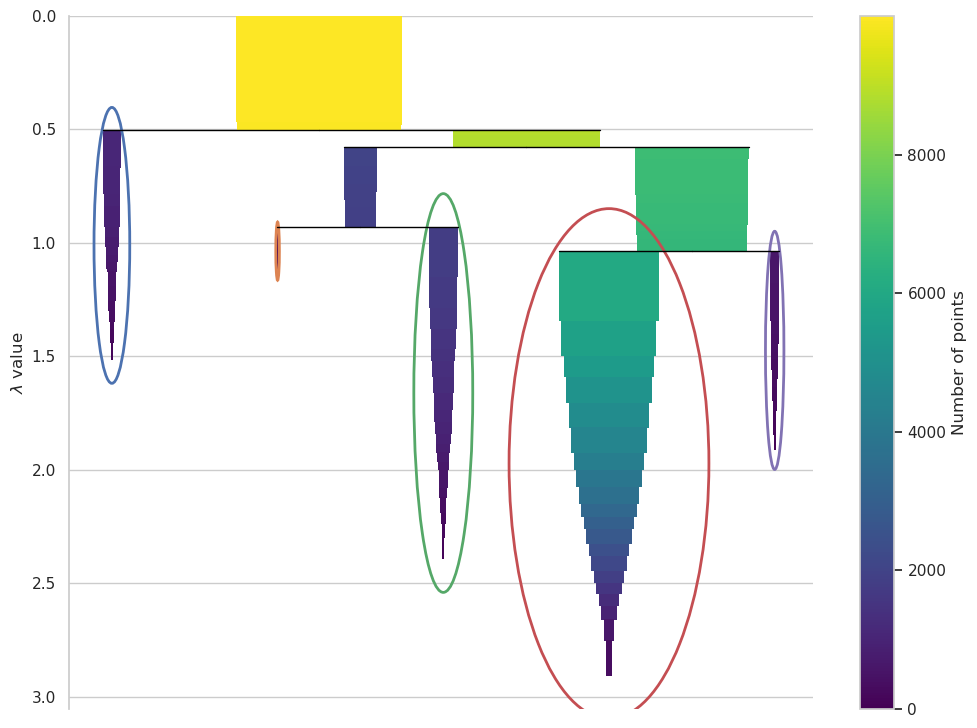

In [37]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

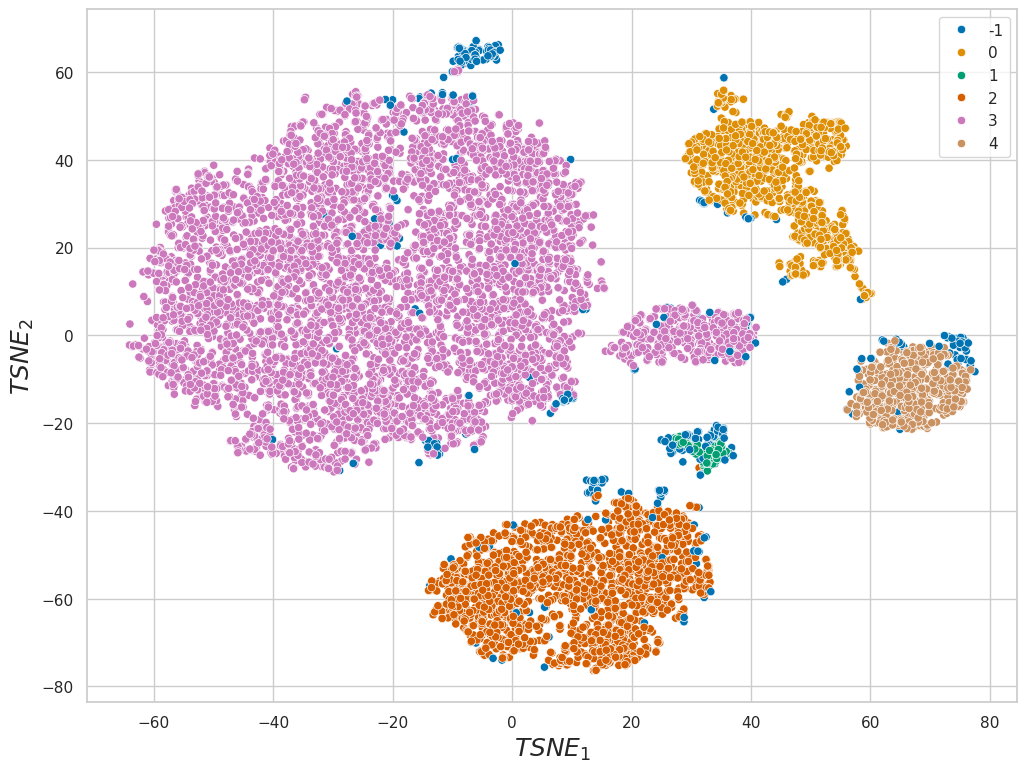

In [38]:
tsne_res_hdb = plot_tsne(scaled_cleaned_fc_data, color=y_pred_hdb)

HDBSCAN помечает выбросы и складываает их в "кластер -1".

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

Не то, чтобы удалось. Наиболее близка к этому я была при использовании AgglomerativeClustering с параметрами euclidean/ward, силуэт не максимальный, но достаточно хороший. На втором месте - результат от HDBScan. Но если смотреть на силуэт скор - лучше всех один большой кластер от AgglomerativeClustering manhattan/single ~~сарказм~~.  Видимо, алгоритмы кластеризации ловят что-то еще, что не ловит tSNE, какие-то другие зависимости.

Silhuette score: 0.4809


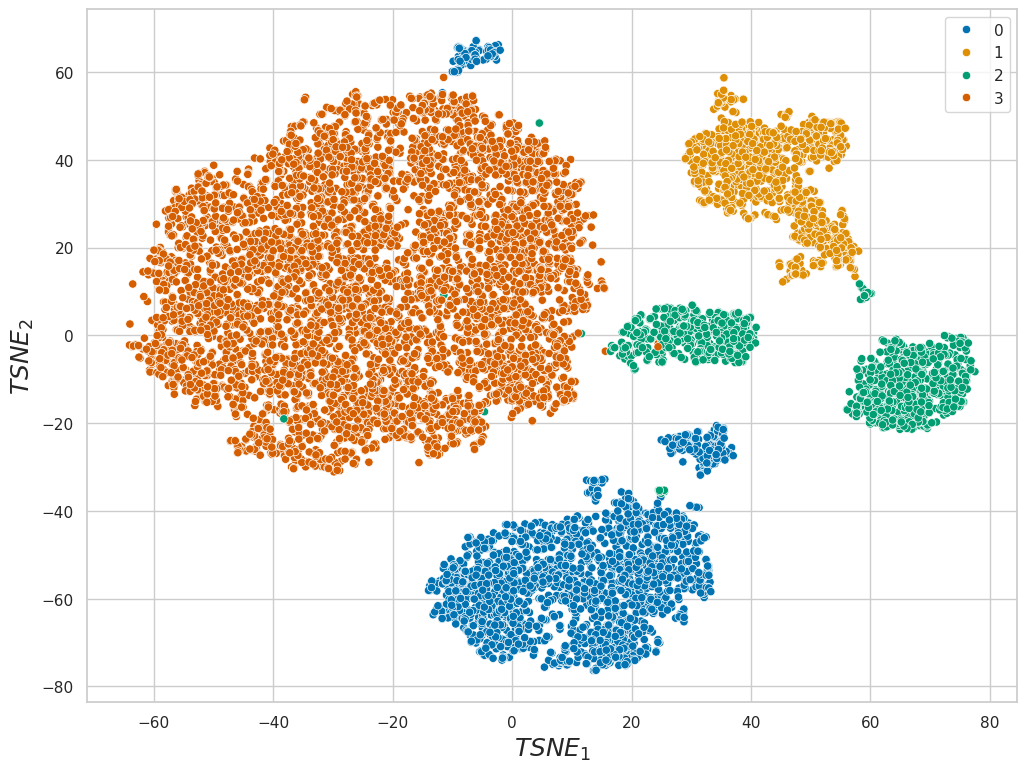

In [39]:
agg4 = AgglomerativeClustering(n_clusters=4)
y_pred_agg4 = agg4.fit_predict(scaled_cleaned_fc_data)
sil = silhouette_score(scaled_cleaned_fc_data, y_pred_agg4)
print(f"Silhuette score: {round(sil, 4)}")
tsne_res_agg4 = plot_tsne(scaled_cleaned_fc_data, color=y_pred_agg4)

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

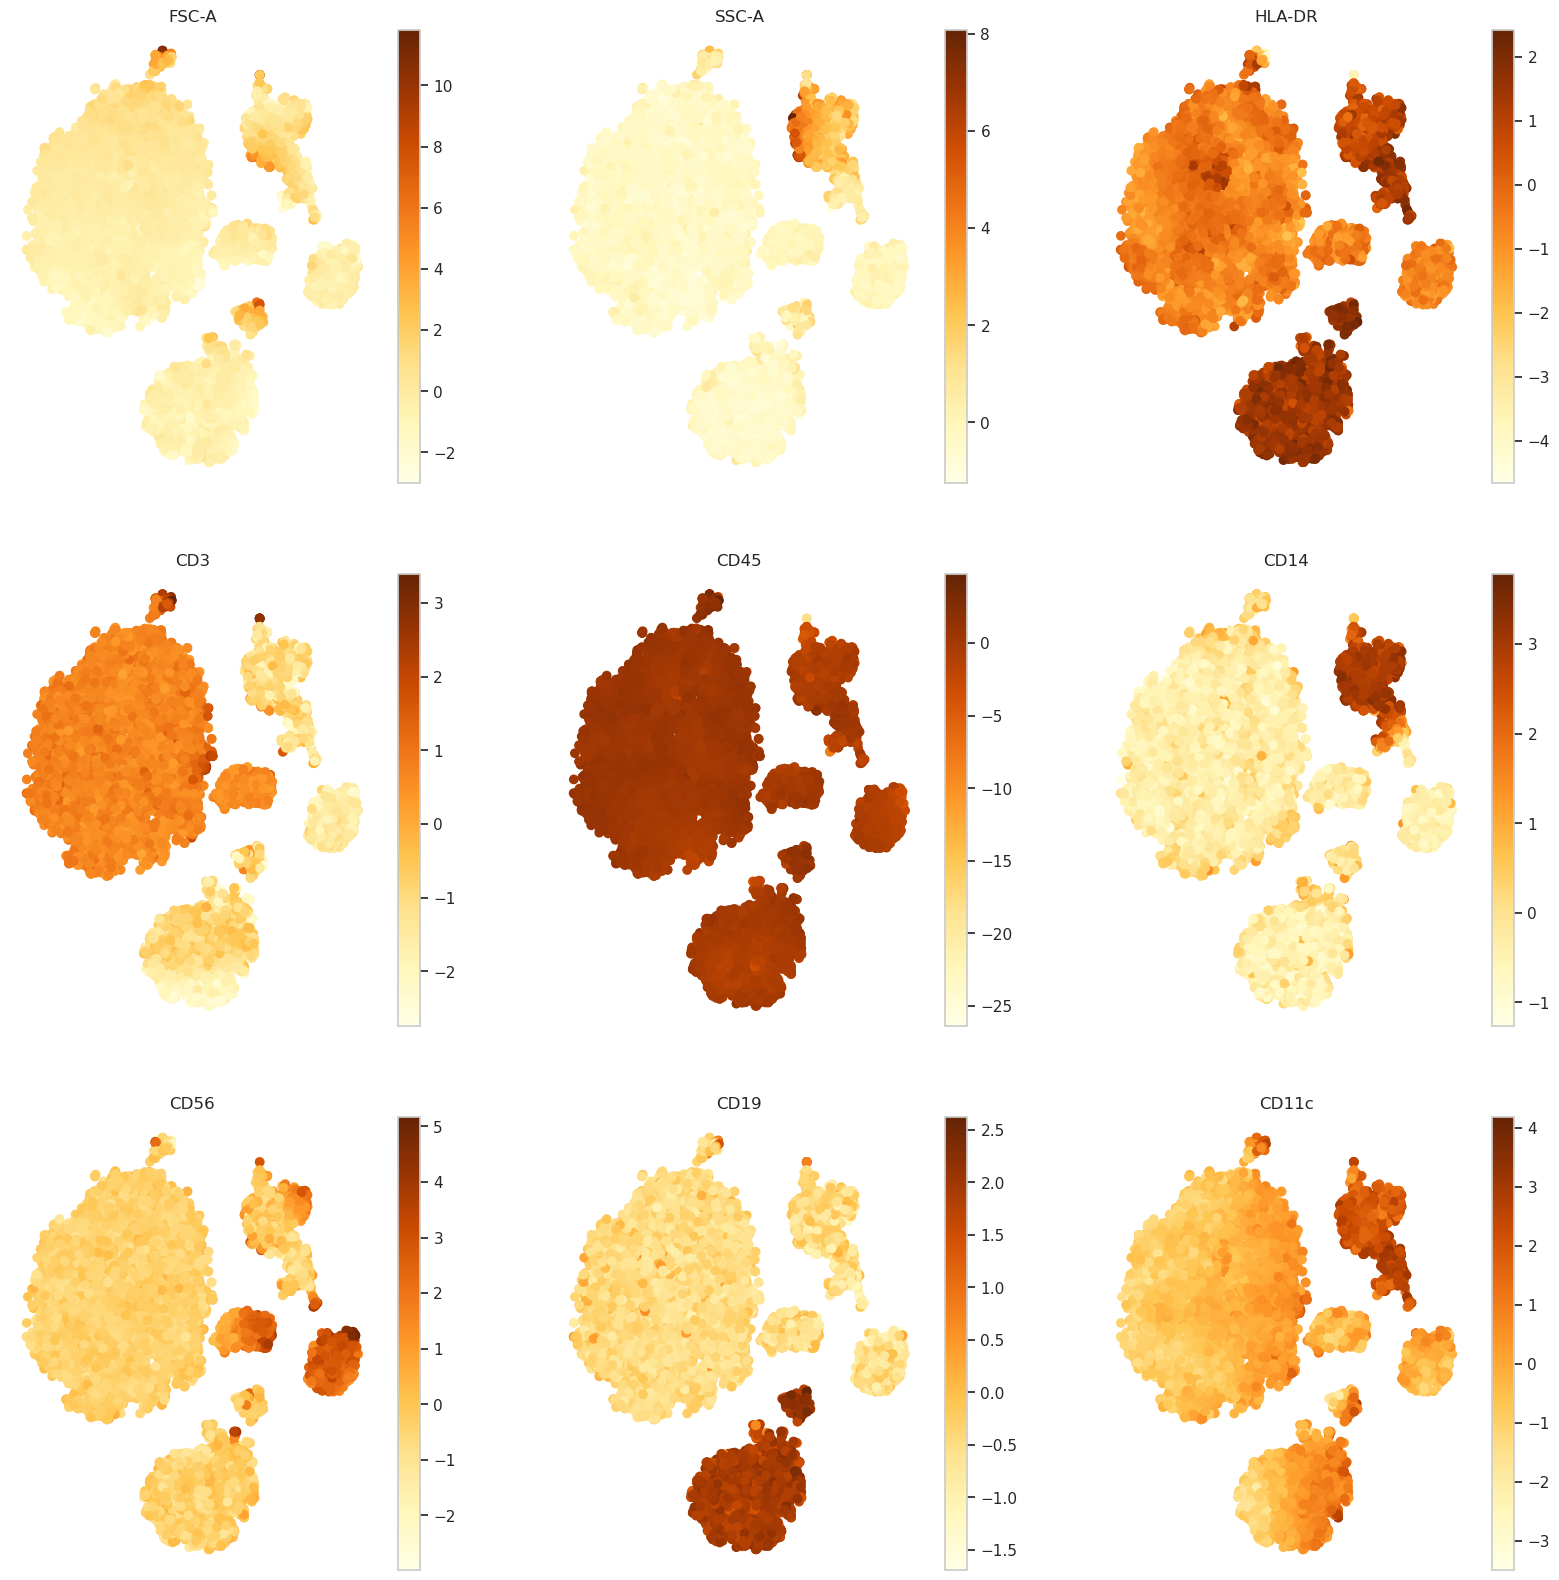

In [40]:
scaled_cleaned_fc_data = pd.DataFrame(scaled_cleaned_fc_data, columns=fc_data.columns)
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=scaled_cleaned_fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [41]:
cell_type_cluster_map = {0: "B-cells",  # CD19
                         1: "Other",   #CD14
                         2: "NK",  #CD56 
                         3: "T-cells"} #CD3

In [42]:
labeled_fc_data = cleaned_fc_data.assign(Population=agg4.labels_)  # я тут убрала скалирование, чтобы скалировать в разделе 3.4
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [43]:
labeled_fc_data.Population.value_counts()

Population
T-cells    5657
B-cells    2126
NK         1135
Other      1081
Name: count, dtype: int64

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [44]:
labeled_fc_data.to_csv('../data_folder/processed_data/fc_data.csv', index=False)

#### 3.4. Автоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

In [45]:
X , y = labeled_fc_data.drop('Population', axis=1), labeled_fc_data[['Population']]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=SEED)

In [46]:
logreg_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression())
])
logreg_pipeline

Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression())])

In [47]:
logreg_pipeline.fit(X_train, y_train)
predicted_classes = logreg_pipeline.predict(X_test)
f1 = f1_score(y_test, predicted_classes, average="macro")
print(f'f1_score = {round(f1, 4)}')

f1_score = 0.994


### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Этой весной я поеду разве что кукушечкой, а хотелось бы на Филиппины. Была там один раз в 2019 году, у меня случился культурный шок - небоскребы по соседству с домами, похожими больше на мусорную кучу, отдельная история - дорожное движение. Но, когда мы уехали из Манилы и приплыли на Миндоро в маленькую деревеньку, стало намного лучше. Там я отметила свой лучший день рождения - вместо какого-то там застолья мы пошли с проводником  к маленькому водопадику, а самое прекрасное - из-за разницы в часовых поясах мне никто не звонил, все просто писали сообщения, это было прекрасно. А еще там я первый раз (и пока единственный) ныряла с аквалангом, маску прочищать правда так и не научилась)) Как же красиво под водой!!! А еще там было много маленьких гекконов, которые орали по ночам!)

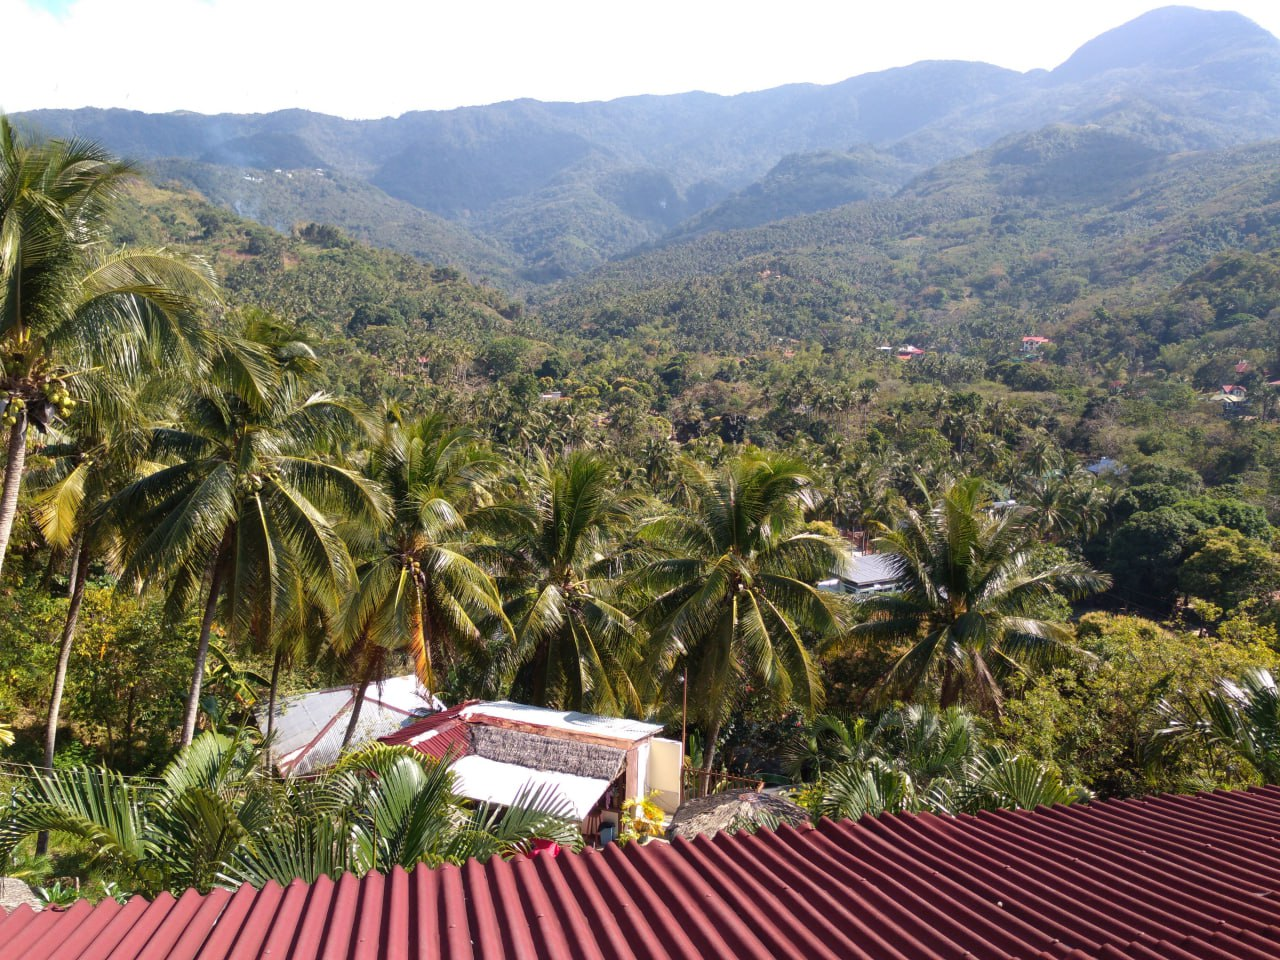

In [55]:
img1 = display.Image('../data_folder/raw_data/photo_1.jpg')
img2 = display.Image('../data_folder/raw_data/photo_1.jpg')
img3 = display.Image('../data_folder/raw_data/photo_1.jpg')
img4 = display.Image('../data_folder/raw_data/photo_1.jpg')
img5 = display.Image('../data_folder/raw_data/photo_1.jpg')

display.display(img1)

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Медитация в скопление точек. Найс

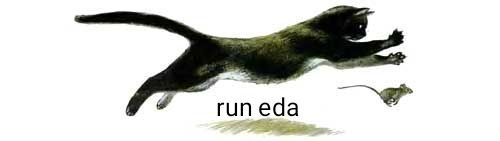

In [54]:
display.Image('../data_folder/raw_data/run_eda.jpg')  #куда же без котика